# Experiments

### Setup

In [1]:
# You can set them inline
import os
os.environ["OPENAI_API_KEY"] = ""
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langsmith-academy"

In [2]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv(dotenv_path=r"C:/Users/hp/Desktop/CODING/AkshitBaliyan-langsmith-Mat496/AkshitBaliyan-langsmith-MAT496/.env", override=True)

True

Here is the RAG Application that we've been working with throughout this course

In [5]:
import os
import tempfile
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders.sitemap import SitemapLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings
from langsmith import traceable
from openai import OpenAI
from typing import List
import nest_asyncio

# TODO: Configure this model!
MODEL_NAME = "gpt-5-nano"
MODEL_PROVIDER = "openai"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

openai_client = OpenAI()

def get_vector_db_retriever():
    persist_path = os.path.join(tempfile.gettempdir(), "union.parquet")
    embd = OpenAIEmbeddings()

    # If vector store exists, then load it
    if os.path.exists(persist_path):
        vectorstore = SKLearnVectorStore(
            embedding=embd,
            persist_path=persist_path,
            serializer="parquet"
        )
        return vectorstore.as_retriever(lambda_mult=0)

    # Otherwise, index LangSmith documents and create new vector store
    ls_docs_sitemap_loader = SitemapLoader(web_path="https://docs.smith.langchain.com/sitemap.xml", continue_on_failure=True)
    ls_docs = ls_docs_sitemap_loader.load()

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=500, chunk_overlap=0
    )
    doc_splits = text_splitter.split_documents(ls_docs)

    vectorstore = SKLearnVectorStore.from_documents(
        documents=doc_splits,
        embedding=embd,
        persist_path=persist_path,
        serializer="parquet"
    )
    vectorstore.persist()
    return vectorstore.as_retriever(lambda_mult=0)

nest_asyncio.apply()
retriever = get_vector_db_retriever()

"""
retrieve_documents
- Returns documents fetched from a vectorstore based on the user's question
"""
@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

"""
generate_response
- Calls `call_openai` to generate a model response after formatting inputs
"""
@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

"""
call_openai
- Returns the chat completion output from OpenAI
"""
@traceable(
    run_type="llm",
    metadata={
        "ls_provider": MODEL_PROVIDER,
        "ls_model_name": MODEL_NAME
    }
)
def call_openai(messages: List[dict]) -> str:
    return openai_client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
    )

"""
langsmith_rag
- Calls `retrieve_documents` to fetch documents
- Calls `generate_response` to generate a response based on the fetched documents
- Returns the model response
"""
@traceable(run_type="chain")
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


### Experiment

Here is a code snippet that should look similar to what you see from the starter code!

There are a few important components here.

1. We have defined an Evaluator
2. We pipe our dataset examples (dict) to the shape of input that our function `langsmith_rag` takes (str) using a target function

In [4]:
from langsmith import evaluate, Client

client = Client()
dataset_name = "RAG Application Golden Dataset"

def is_concise_enough(reference_outputs: dict, outputs: dict) -> dict:
    score = len(outputs["output"]) < 1.5 * len(reference_outputs["output"])
    return {"key": "is_concise", "score": int(score)}

def target_function(inputs: dict):
    return langsmith_rag(inputs["question"])

evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="gpt-4o"
)

c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


View the evaluation results for experiment: 'gpt-4o-d0e519c4' at:
https://smith.langchain.com/o/edf0d7ac-cbe4-4e3d-bceb-6e83aee68d4d/datasets/6962829c-6b26-4f99-a395-bee35c8ad579/compare?selectedSessions=03e3ffb9-f976-42bd-89b7-0ddae7e5dc12




0it [00:00, ?it/s]Error running evaluator <DynamicRunEvaluator is_concise_enough> on run 8ac6efba-0c72-4b42-bc0f-02cf23309702: KeyError('output')
Traceback (most recent call last):
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\evaluation\_runner.py", line 1620, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(  # type: ignore[call-arg]
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\evaluation\evaluator.py", line 351, in evaluate_run
    result = self.func(
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\run_helpers.py", line 703, in wrapper
    function_result = run_container["context"].run(
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\evaluation\evaluator.py", line 777, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\hp\AppData\Local\Temp\ipykernel_6640\1710287486.py", line 7, in is_concise_enough
    score = len(outputs["output"]) < 1.5 * len(refere

,inputs.question,outputs.output,error,reference.response,feedback.wrapper,execution_time,example_id,id,reference.output,feedback.is_concise
0,How can I visualize the data collected by Lang...,"In LangSmith, you can visualize data collected...",None,LangSmith provides built-in visualization tool...,NaN,2.954698,61e6d127-1295-45a8-8e21-3ae522eb31d4,8ac6efba-0c72-4b42-bc0f-02cf23309702,NaN,NaN
1,Is there a community or support forum for Lang...,The provided text does not mention a specific ...,None,"Yes, LangSmith has a dedicated community forum...",NaN,2.269837,75827eb1-7f6c-42e7-bcc1-772b4cd5d8ec,58cbad7b-5df7-4757-ad05-f2e62e739500,NaN,NaN
2,What types of databases can be connected with ...,LangSmith can connect with ClickHouse for high...,None,LangSmith supports connections with several ty...,NaN,1.996896,d5445797-47a0-47c4-9788-a5d059623756,08879643-0705-4c4f-bbbb-c6a56282ee0d,NaN,NaN
3,Can I integrate LangSmith with other machine l...,The provided context does not specify whether ...,None,"Yes, LangSmith can be integrated with various ...",NaN,1.489372,e00ebb81-ad96-4b03-8b62-5d71c0eca6eb,231b347a-8b34-4e62-b961-326f78724261,NaN,NaN
4,What kind of analytics features does LangSmith...,LangSmith offers features for comparing multip...,None,LangSmith offers analytics features that inclu...,NaN,2.229665,fcca4d64-582a-4950-b9d5-379553ce85e2,869fe679-0d0e-4363-8ef6-55ce8c7a20a7,NaN,NaN
5,Is there a Javascript Langsmith extension?,"Yes, there is a JavaScript LangSmith extension...",None,Yes!,NaN,1.634766,6bed6e10-c008-4c34-9347-a599a88919a6,e1e07c1a-9dba-49fb-9d40-7dac6d2568eb,NaN,NaN
6,How do I create user feedback with the LangSmi...,To create user feedback with the LangSmith SDK...,None,NaN,NaN,2.232147,7f5fff6b-cc71-4050-9706-2d3bf6261c66,758ca537-bbdc-4def-9e10-feeaf2eb1ce9,To create user feedback with the LangSmith SDK...,1.0
7,How do I set up tracing to LangSmith if I'm us...,To set up tracing to LangSmith using LangChain...,None,NaN,NaN,1.917670,9c944abe-8a8a-4a8c-9b1a-77d4fae2a1cb,83bea00d-aa2a-4d21-961a-aea946afa749,"To set up tracing to LangSmith with LangChain,...",1.0
8,How do I pass metadata in with @traceable?,"To pass metadata when using `@traceable`, you ...",None,NaN,NaN,2.759745,000bc6d6-30f8-4788-9537-cf71b204c0d0,01a93a23-0dc8-4f5c-aac8-f1cc9cabfed6,You can pass metadata with the @traceable deco...,0.0
9,What is LangSmith used for in three sentences?,LangSmith is used to run and manage experiment...,None,NaN,NaN,24.952183,1778a7ea-bda1-444d-9ed0-808828df3af9,a24a1740-a199-4692-ae21-dfd29e80d1b9,LangSmith is a platform designed for the devel...,1.0


### Modifying your Application

Now, let's change our model to gpt-35-turbo and see how it performs!

Make this change, and then run this code snippet!

In [6]:
from langsmith import evaluate, Client
from langsmith.schemas import Example, Run

def target_function(inputs: dict):
    return langsmith_rag(inputs["question"])

evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="gpt-5-nano"
)

View the evaluation results for experiment: 'gpt-5-nano-1151f842' at:
https://smith.langchain.com/o/edf0d7ac-cbe4-4e3d-bceb-6e83aee68d4d/datasets/6962829c-6b26-4f99-a395-bee35c8ad579/compare?selectedSessions=70e120b0-4ea6-429e-8efe-7340ecbe168b




0it [00:00, ?it/s]Error running evaluator <DynamicRunEvaluator is_concise_enough> on run 06304215-7fac-48c8-89e7-a7387a19b766: KeyError('output')
Traceback (most recent call last):
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\evaluation\_runner.py", line 1620, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(  # type: ignore[call-arg]
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\evaluation\evaluator.py", line 351, in evaluate_run
    result = self.func(
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\run_helpers.py", line 703, in wrapper
    function_result = run_container["context"].run(
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\evaluation\evaluator.py", line 777, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\hp\AppData\Local\Temp\ipykernel_6640\1710287486.py", line 7, in is_concise_enough
    score = len(outputs["output"]) < 1.5 * len(refere

,inputs.question,outputs.output,error,reference.response,feedback.wrapper,execution_time,example_id,id,reference.output,feedback.is_concise
0,How can I visualize the data collected by Lang...,- Use the LangSmith UI to view all experiments...,None,LangSmith provides built-in visualization tool...,NaN,5.337164,61e6d127-1295-45a8-8e21-3ae522eb31d4,06304215-7fac-48c8-89e7-a7387a19b766,NaN,NaN
1,Is there a community or support forum for Lang...,I don’t know.,None,"Yes, LangSmith has a dedicated community forum...",NaN,3.663671,75827eb1-7f6c-42e7-bcc1-772b4cd5d8ec,a17ef07e-f802-4f0f-b8ea-febadd270c7b,NaN,NaN
2,What types of databases can be connected with ...,LangSmith can connect to ClickHouse (for trace...,None,LangSmith supports connections with several ty...,NaN,3.919662,d5445797-47a0-47c4-9788-a5d059623756,03d8a567-a106-49c0-8543-d8db08652ff3,NaN,NaN
3,Can I integrate LangSmith with other machine l...,The provided context only mentions LangSmith i...,None,"Yes, LangSmith can be integrated with various ...",NaN,3.142774,e00ebb81-ad96-4b03-8b62-5d71c0eca6eb,d7b58ebc-1613-4bd8-89e8-6b4bae2cbe46,NaN,NaN
4,What kind of analytics features does LangSmith...,LangSmith provides analytics around experiment...,None,LangSmith offers analytics features that inclu...,NaN,4.272532,fcca4d64-582a-4950-b9d5-379553ce85e2,fa3393d2-82f9-4372-8ea3-da27f61b4d90,NaN,NaN
5,Is there a Javascript Langsmith extension?,Yes. LangSmith supports JavaScript/TypeScript ...,None,Yes!,NaN,4.005106,6bed6e10-c008-4c34-9347-a599a88919a6,f9fabb42-e541-4321-ab29-aabe3d0c83db,NaN,NaN
6,How do I create user feedback with the LangSmi...,- Use LangSmith SDK’s create_feedback() (or cr...,None,NaN,NaN,6.724647,7f5fff6b-cc71-4050-9706-2d3bf6261c66,e2bf9dc5-4495-426c-afbd-c4f1e92c31ba,To create user feedback with the LangSmith SDK...,1.0
7,How do I set up tracing to LangSmith if I'm us...,"- Run LangSmith (self-hosted or cloud) and, if...",None,NaN,NaN,6.211907,9c944abe-8a8a-4a8c-9b1a-77d4fae2a1cb,882bb885-3af3-4e54-ab64-39810c647491,"To set up tracing to LangSmith with LangChain,...",0.0
8,How do I pass metadata in with @traceable?,You pass metadata by including it under experi...,None,NaN,NaN,8.741902,000bc6d6-30f8-4788-9537-cf71b204c0d0,09d15f43-0e0e-4dfd-810f-4493aa354ff5,You can pass metadata with the @traceable deco...,1.0
9,What is LangSmith used for in three sentences?,LangSmith is a platform you run in Kubernetes ...,None,NaN,NaN,3.817796,1778a7ea-bda1-444d-9ed0-808828df3af9,ecc5cda4-d051-4f62-9cb2-253537799f8c,LangSmith is a platform designed for the devel...,1.0


### Running over Different pieces of Data

##### Dataset Version

You can execute an experiment on a specific version of a dataset in the sdk by using the `as_of` parameter in `list_examples`

Let's try running on just our initial dataset.

In [9]:
evaluate(
    target_function,
    data=client.list_examples(dataset_name=dataset_name, as_of="latest"),   # We use as_of to specify a version
    evaluators=[is_concise_enough],
    experiment_prefix="initial dataset version"
)

View the evaluation results for experiment: 'initial dataset version-3f8b5085' at:
https://smith.langchain.com/o/edf0d7ac-cbe4-4e3d-bceb-6e83aee68d4d/datasets/6962829c-6b26-4f99-a395-bee35c8ad579/compare?selectedSessions=c5822f7e-84fd-4168-b063-0fa070128362




0it [00:00, ?it/s]Error running evaluator <DynamicRunEvaluator is_concise_enough> on run a3dff39f-941f-4ec6-972c-e0d164cd45a6: KeyError('output')
Traceback (most recent call last):
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\evaluation\_runner.py", line 1620, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(  # type: ignore[call-arg]
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\evaluation\evaluator.py", line 351, in evaluate_run
    result = self.func(
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\run_helpers.py", line 703, in wrapper
    function_result = run_container["context"].run(
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\evaluation\evaluator.py", line 777, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\hp\AppData\Local\Temp\ipykernel_6640\1710287486.py", line 7, in is_concise_enough
    score = len(outputs["output"]) < 1.5 * len(refere

,inputs.question,outputs.output,error,reference.response,feedback.wrapper,execution_time,example_id,id,reference.output,feedback.is_concise
0,How can I visualize the data collected by Lang...,"- In LangSmith, you visualize data by viewing ...",None,LangSmith provides built-in visualization tool...,NaN,4.650303,61e6d127-1295-45a8-8e21-3ae522eb31d4,a3dff39f-941f-4ec6-972c-e0d164cd45a6,NaN,NaN
1,Is there a community or support forum for Lang...,The provided context does not mention any comm...,None,"Yes, LangSmith has a dedicated community forum...",NaN,3.707990,75827eb1-7f6c-42e7-bcc1-772b4cd5d8ec,22530482-3d06-45fe-a4a7-867f9e13a4c2,NaN,NaN
2,What types of databases can be connected with ...,LangSmith can connect to external ClickHouse (...,None,LangSmith supports connections with several ty...,NaN,3.521077,d5445797-47a0-47c4-9788-a5d059623756,b7050b23-1b23-44ba-977e-0183fa928c56,NaN,NaN
3,Can I integrate LangSmith with other machine l...,The provided docs only mention LangSmith integ...,None,"Yes, LangSmith can be integrated with various ...",NaN,3.304107,e00ebb81-ad96-4b03-8b62-5d71c0eca6eb,4ff81a1f-e55e-4b6e-bcee-8321ee46b5f2,NaN,NaN
4,What kind of analytics features does LangSmith...,LangSmith supports analytics by letting you ru...,None,LangSmith offers analytics features that inclu...,NaN,4.607770,fcca4d64-582a-4950-b9d5-379553ce85e2,932da4ef-72ef-4da2-a94f-b47181192427,NaN,NaN
5,Is there a Javascript Langsmith extension?,Yes. LangSmith integrates with LangChain in Ja...,None,Yes!,NaN,7.021193,6bed6e10-c008-4c34-9347-a599a88919a6,1d01b07d-8f42-4450-b723-44472b90d520,NaN,NaN
6,How do I create user feedback with the LangSmi...,Use the LangSmith SDK’s create_feedback() (or ...,None,NaN,NaN,20.690346,7f5fff6b-cc71-4050-9706-2d3bf6261c66,347d7621-2c1f-4f26-9f41-a648559dfd4a,To create user feedback with the LangSmith SDK...,1.0
7,How do I set up tracing to LangSmith if I'm us...,- Run LangSmith (self-hosted or hosted) and se...,None,NaN,NaN,7.790667,9c944abe-8a8a-4a8c-9b1a-77d4fae2a1cb,2396c8e7-aaae-4220-9b36-b010d3ba4863,"To set up tracing to LangSmith with LangChain,...",1.0
8,How do I pass metadata in with @traceable?,Pass metadata by including it in the experimen...,None,NaN,NaN,9.685562,000bc6d6-30f8-4788-9537-cf71b204c0d0,1aced75e-061f-4832-aab6-cbf49ba4fab8,You can pass metadata with the @traceable deco...,1.0
9,What is LangSmith used for in three sentences?,LangSmith is used to run and manage experiment...,None,NaN,NaN,5.227793,1778a7ea-bda1-444d-9ed0-808828df3af9,82806763-e62b-4032-82c9-709f41ac66f1,LangSmith is a platform designed for the devel...,1.0


##### Dataset Split

You can run an experiment on a specific split of your dataset, let's try running on the Crucial Examples split.

In [11]:
evaluate(
    target_function,
    data=client.list_examples(dataset_name=dataset_name, splits=["AI-Generated"]),  # We pass in a list of Splits
    evaluators=[is_concise_enough],
    experiment_prefix="Crucial Examples split"
)

View the evaluation results for experiment: 'Crucial Examples split-2d190740' at:
https://smith.langchain.com/o/edf0d7ac-cbe4-4e3d-bceb-6e83aee68d4d/datasets/6962829c-6b26-4f99-a395-bee35c8ad579/compare?selectedSessions=1041fd11-d553-4f36-b41f-dc85d5d60994




0it [00:00, ?it/s]Error running evaluator <DynamicRunEvaluator is_concise_enough> on run fe0f62f8-ce2b-4411-af4e-9a306b5133dc: KeyError('output')
Traceback (most recent call last):
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\evaluation\_runner.py", line 1620, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(  # type: ignore[call-arg]
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\evaluation\evaluator.py", line 351, in evaluate_run
    result = self.func(
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\run_helpers.py", line 703, in wrapper
    function_result = run_container["context"].run(
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\evaluation\evaluator.py", line 777, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\hp\AppData\Local\Temp\ipykernel_6640\1710287486.py", line 7, in is_concise_enough
    score = len(outputs["output"]) < 1.5 * len(refere

,inputs.question,outputs.output,error,reference.response,feedback.wrapper,execution_time,example_id,id
0,How can I visualize the data collected by Lang...,"- In LangSmith, you visualize data by viewing ...",None,LangSmith provides built-in visualization tool...,None,4.263652,61e6d127-1295-45a8-8e21-3ae522eb31d4,fe0f62f8-ce2b-4411-af4e-9a306b5133dc
1,Is there a community or support forum for Lang...,I don’t know from the provided context—the pag...,None,"Yes, LangSmith has a dedicated community forum...",None,3.972346,75827eb1-7f6c-42e7-bcc1-772b4cd5d8ec,e81ef9ab-5e4f-44b1-a10a-39beb0450e29
2,What types of databases can be connected with ...,"LangSmith can be connected to ClickHouse, Post...",None,LangSmith supports connections with several ty...,None,4.980499,d5445797-47a0-47c4-9788-a5d059623756,5264e21e-b1f4-4353-b7f3-75e50e491484
3,Can I integrate LangSmith with other machine l...,The provided information only mentions LangSmi...,None,"Yes, LangSmith can be integrated with various ...",None,33.951002,e00ebb81-ad96-4b03-8b62-5d71c0eca6eb,2e061ed0-eaf3-4054-94b6-a54abfe24750
4,What kind of analytics features does LangSmith...,LangSmith provides analytics around traces and...,None,LangSmith offers analytics features that inclu...,None,7.127821,fcca4d64-582a-4950-b9d5-379553ce85e2,150fefd5-443e-4b6a-a3c2-abe25605aa3b


##### Specific Data Points

You can specify individual data points to run an experiment over as well

In [12]:
evaluate(
    target_function,
    data=client.list_examples(
        dataset_name=dataset_name, 
        example_ids=[   # We pass in a specific list of example_ids
            # TODO: You will need to paste in your own example ids for this to work!
            "75827eb1-7f6c-42e7-bcc1-772b4cd5d8ec",
            "b04f0ee6-5277-40f0-b707-5f47757814cb",
            "1778a7ea-bda1-444d-9ed0-808828df3af9"
        ]
    ),
    evaluators=[is_concise_enough],
    experiment_prefix="two specific example ids"
)

View the evaluation results for experiment: 'two specific example ids-ced47a7e' at:
https://smith.langchain.com/o/edf0d7ac-cbe4-4e3d-bceb-6e83aee68d4d/datasets/6962829c-6b26-4f99-a395-bee35c8ad579/compare?selectedSessions=2e496345-e37a-4e0f-98f1-71bcefd43ec5




1it [00:03,  3.36s/it]Error running evaluator <DynamicRunEvaluator is_concise_enough> on run 4b138587-ca4b-445d-bf54-2c42df83f1b0: KeyError('output')
Traceback (most recent call last):
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\evaluation\_runner.py", line 1620, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(  # type: ignore[call-arg]
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\evaluation\evaluator.py", line 351, in evaluate_run
    result = self.func(
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\run_helpers.py", line 703, in wrapper
    function_result = run_container["context"].run(
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\evaluation\evaluator.py", line 777, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\hp\AppData\Local\Temp\ipykernel_6640\1710287486.py", line 7, in is_concise_enough
    score = len(outputs["output"]) < 1.5 * len(re

,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id,reference.response,feedback.wrapper
0,What is LangSmith used for in three sentences?,LangSmith is a platform for running and evalua...,None,LangSmith is a platform designed for the devel...,1.0,3.360177,1778a7ea-bda1-444d-9ed0-808828df3af9,8ba60dc0-0c4c-4f32-9d06-077930ac8031,NaN,NaN
1,Is there a community or support forum for Lang...,The provided context doesn’t mention a communi...,None,NaN,NaN,4.837630,75827eb1-7f6c-42e7-bcc1-772b4cd5d8ec,4b138587-ca4b-445d-bf54-2c42df83f1b0,"Yes, LangSmith has a dedicated community forum...",NaN
2,Does LangSmith support offline evaluation?,The LangSmith docs focus on online evaluators ...,None,"Yes, LangSmith supports offline evaluation thr...",1.0,4.320767,b04f0ee6-5277-40f0-b707-5f47757814cb,48a54c7d-ff4e-4461-8468-63cfead31bda,NaN,NaN


### Other Parameters

##### Repetitions

You can run an experiment several times to make sure you have consistent results

In [13]:
evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="two repetitions",
    num_repetitions=2   # This field defaults to 1
)

View the evaluation results for experiment: 'two repetitions-de49c093' at:
https://smith.langchain.com/o/edf0d7ac-cbe4-4e3d-bceb-6e83aee68d4d/datasets/6962829c-6b26-4f99-a395-bee35c8ad579/compare?selectedSessions=da882688-89c6-4b32-9007-8671f44cdf57




0it [00:00, ?it/s]Error running evaluator <DynamicRunEvaluator is_concise_enough> on run 4235e2de-0841-4cc1-b211-632553a88050: KeyError('output')
Traceback (most recent call last):
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\evaluation\_runner.py", line 1620, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(  # type: ignore[call-arg]
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\evaluation\evaluator.py", line 351, in evaluate_run
    result = self.func(
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\run_helpers.py", line 703, in wrapper
    function_result = run_container["context"].run(
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\evaluation\evaluator.py", line 777, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\hp\AppData\Local\Temp\ipykernel_6640\1710287486.py", line 7, in is_concise_enough
    score = len(outputs["output"]) < 1.5 * len(refere

,inputs.question,outputs.output,error,reference.response,feedback.wrapper,execution_time,example_id,id,reference.output,feedback.is_concise
0,How can I visualize the data collected by Lang...,- LangSmith provides a UI where you can view a...,None,LangSmith provides built-in visualization tool...,NaN,6.292494,61e6d127-1295-45a8-8e21-3ae522eb31d4,4235e2de-0841-4cc1-b211-632553a88050,NaN,NaN
1,Is there a community or support forum for Lang...,I don’t know from the provided context—the tex...,None,"Yes, LangSmith has a dedicated community forum...",NaN,4.596456,75827eb1-7f6c-42e7-bcc1-772b4cd5d8ec,a4f00fc1-f717-4519-8e09-f8ef0d5f7bdb,NaN,NaN
2,What types of databases can be connected with ...,LangSmith can connect to external ClickHouse (...,None,LangSmith supports connections with several ty...,NaN,4.343055,d5445797-47a0-47c4-9788-a5d059623756,d148bf63-6644-47ae-a927-467a916533b6,NaN,NaN
3,Can I integrate LangSmith with other machine l...,"Based on the available docs, LangSmith is desc...",None,"Yes, LangSmith can be integrated with various ...",NaN,3.721085,e00ebb81-ad96-4b03-8b62-5d71c0eca6eb,1175a0aa-fc53-4c67-bc7b-8026dda4a007,NaN,NaN
4,What kind of analytics features does LangSmith...,LangSmith provides observability analytics for...,None,LangSmith offers analytics features that inclu...,NaN,7.667317,fcca4d64-582a-4950-b9d5-379553ce85e2,0cc2d237-a11d-473e-9776-c19efcdba839,NaN,NaN
5,Is there a Javascript Langsmith extension?,Yes. LangSmith offers JavaScript/TypeScript su...,None,Yes!,NaN,4.488724,6bed6e10-c008-4c34-9347-a599a88919a6,ee9c8ecd-aefe-4d03-972b-64b4c0b8433a,NaN,NaN
6,How do I create user feedback with the LangSmi...,Use the LangSmith SDK's create_feedback() (or ...,None,NaN,NaN,8.411213,7f5fff6b-cc71-4050-9706-2d3bf6261c66,df8300a7-c467-48fe-9aac-7e70badc1f44,To create user feedback with the LangSmith SDK...,1.0
7,How do I set up tracing to LangSmith if I'm us...,Start LangSmith (self-hosted or cloud) and use...,None,NaN,NaN,7.992011,9c944abe-8a8a-4a8c-9b1a-77d4fae2a1cb,a77d0f0a-96a1-4835-a32e-5c45e99c6a8c,"To set up tracing to LangSmith with LangChain,...",1.0
8,How do I pass metadata in with @traceable?,You pass metadata by attaching it to the SDK c...,None,NaN,NaN,11.382852,000bc6d6-30f8-4788-9537-cf71b204c0d0,8448d9cb-e35e-42d6-aec9-e3b12e761293,You can pass metadata with the @traceable deco...,0.0
9,What is LangSmith used for in three sentences?,LangSmith is a platform to run and manage expe...,None,NaN,NaN,5.122319,1778a7ea-bda1-444d-9ed0-808828df3af9,4bef8c9e-e8e4-464c-a234-6dc2f451d087,LangSmith is a platform designed for the devel...,1.0


##### Concurrency
You can also kick off concurrent threads of execution to make your experiments finish faster!

In [14]:
evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="concurrency",
    max_concurrency=3,  # This defaults to None, so this is an improvement!
)

View the evaluation results for experiment: 'concurrency-43149158' at:
https://smith.langchain.com/o/edf0d7ac-cbe4-4e3d-bceb-6e83aee68d4d/datasets/6962829c-6b26-4f99-a395-bee35c8ad579/compare?selectedSessions=37865f10-b35c-44c8-87fc-8c961af89d21




0it [00:00, ?it/s]Error running evaluator <DynamicRunEvaluator is_concise_enough> on run 64374d69-0721-4c4d-b6e8-ec36ed750d72: KeyError('output')
Traceback (most recent call last):
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\evaluation\_runner.py", line 1620, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(  # type: ignore[call-arg]
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\evaluation\evaluator.py", line 351, in evaluate_run
    result = self.func(
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\run_helpers.py", line 703, in wrapper
    function_result = run_container["context"].run(
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\evaluation\evaluator.py", line 777, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\hp\AppData\Local\Temp\ipykernel_6640\1710287486.py", line 7, in is_concise_enough
    score = len(outputs["output"]) < 1.5 * len(refere

,inputs.question,outputs.output,error,reference.response,feedback.wrapper,execution_time,example_id,id,reference.output,feedback.is_concise
0,Is there a community or support forum for Lang...,I don’t know from the provided context.,None,"Yes, LangSmith has a dedicated community forum...",NaN,3.801851,75827eb1-7f6c-42e7-bcc1-772b4cd5d8ec,64374d69-0721-4c4d-b6e8-ec36ed750d72,NaN,NaN
1,What types of databases can be connected with ...,"LangSmith can connect to ClickHouse, PostgreSQ...",None,LangSmith supports connections with several ty...,NaN,4.410144,d5445797-47a0-47c4-9788-a5d059623756,d6adeadf-a08e-4075-aab6-66371b62710e,NaN,NaN
2,How can I visualize the data collected by Lang...,- LangSmith provides a UI where you can view a...,None,LangSmith provides built-in visualization tool...,NaN,5.742813,61e6d127-1295-45a8-8e21-3ae522eb31d4,59b8636f-f029-44ae-93f8-1283ba7e9f0a,NaN,NaN
3,Can I integrate LangSmith with other machine l...,"From the provided material, LangSmith integrat...",None,"Yes, LangSmith can be integrated with various ...",NaN,3.560988,e00ebb81-ad96-4b03-8b62-5d71c0eca6eb,8b04227d-ae23-4114-a3e4-b2e1788e37d2,NaN,NaN
4,Is there a Javascript Langsmith extension?,Yes. LangSmith integrates with LangChain in Ja...,None,Yes!,NaN,4.964154,6bed6e10-c008-4c34-9347-a599a88919a6,3f6c5141-3ed4-453a-b0f7-afcdaef25ad4,NaN,NaN
5,What kind of analytics features does LangSmith...,- LangSmith provides experiment analytics: you...,None,LangSmith offers analytics features that inclu...,NaN,8.730830,fcca4d64-582a-4950-b9d5-379553ce85e2,4e840d7c-511f-42cd-80bc-1bb09c9cef5a,NaN,NaN
6,How do I create user feedback with the LangSmi...,- Use the LangSmith SDK function create_feedba...,None,NaN,NaN,6.186741,7f5fff6b-cc71-4050-9706-2d3bf6261c66,e5303436-66ca-4247-a9db-d441043e3727,To create user feedback with the LangSmith SDK...,1.0
7,How do I set up tracing to LangSmith if I'm us...,- Start your LangSmith instance (self-hosted o...,None,NaN,NaN,8.064213,9c944abe-8a8a-4a8c-9b1a-77d4fae2a1cb,537a0f98-2531-498b-904c-c2ef4d63cee8,"To set up tracing to LangSmith with LangChain,...",1.0
8,What is LangSmith used for in three sentences?,LangSmith is used to run multiple experiments ...,None,NaN,NaN,5.631813,1778a7ea-bda1-444d-9ed0-808828df3af9,a39f83a6-a4c5-4584-84d3-c853760191b4,LangSmith is a platform designed for the devel...,1.0
9,How do I pass metadata in with @traceable?,"- To pass metadata with @traceable, include a ...",None,NaN,NaN,7.635977,000bc6d6-30f8-4788-9537-cf71b204c0d0,297ffff0-478b-4083-860b-7eb279969f96,You can pass metadata with the @traceable deco...,1.0


##### Metadata 

You can (and should) add metadata to your experiments, to make them easier to find in the UI

In [15]:
evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="metadata added",
    metadata={  # We can pass custom metadata for the experiment, such as the model name
        "model_name": MODEL_NAME
    }
)

View the evaluation results for experiment: 'metadata added-565a6bf0' at:
https://smith.langchain.com/o/edf0d7ac-cbe4-4e3d-bceb-6e83aee68d4d/datasets/6962829c-6b26-4f99-a395-bee35c8ad579/compare?selectedSessions=9f84975e-afe5-4145-99ce-4bc55cd09ebe




0it [00:00, ?it/s]Error running evaluator <DynamicRunEvaluator is_concise_enough> on run b752e2ef-f2c2-4e47-95b6-2cbd2a5405fa: KeyError('output')
Traceback (most recent call last):
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\evaluation\_runner.py", line 1620, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(  # type: ignore[call-arg]
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\evaluation\evaluator.py", line 351, in evaluate_run
    result = self.func(
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\run_helpers.py", line 703, in wrapper
    function_result = run_container["context"].run(
  File "c:\Users\hp\anaconda3\envs\Langchain\lib\site-packages\langsmith\evaluation\evaluator.py", line 777, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\hp\AppData\Local\Temp\ipykernel_6640\1710287486.py", line 7, in is_concise_enough
    score = len(outputs["output"]) < 1.5 * len(refere

,inputs.question,outputs.output,error,reference.response,feedback.wrapper,execution_time,example_id,id,reference.output,feedback.is_concise
0,How can I visualize the data collected by Lang...,- Visualize LangSmith data directly in the Lan...,None,LangSmith provides built-in visualization tool...,NaN,5.347879,61e6d127-1295-45a8-8e21-3ae522eb31d4,b752e2ef-f2c2-4e47-95b6-2cbd2a5405fa,NaN,NaN
1,Is there a community or support forum for Lang...,I don’t see any information in the provided co...,None,"Yes, LangSmith has a dedicated community forum...",NaN,3.194330,75827eb1-7f6c-42e7-bcc1-772b4cd5d8ec,e5161182-81f7-4c7c-bb3c-dce1fab49581,NaN,NaN
2,What types of databases can be connected with ...,- ClickHouse (primary data store for traces an...,None,LangSmith supports connections with several ty...,NaN,4.432960,d5445797-47a0-47c4-9788-a5d059623756,be1ee8c5-2486-416d-bae2-38840d1677d3,NaN,NaN
3,Can I integrate LangSmith with other machine l...,"From the provided context, LangSmith integrate...",None,"Yes, LangSmith can be integrated with various ...",NaN,4.082211,e00ebb81-ad96-4b03-8b62-5d71c0eca6eb,df37e99f-bfbc-49e1-86c8-d6fa086dd768,NaN,NaN
4,What kind of analytics features does LangSmith...,LangSmith lets you view all experiments tied t...,None,LangSmith offers analytics features that inclu...,NaN,6.938739,fcca4d64-582a-4950-b9d5-379553ce85e2,19e9e68b-b92f-494e-abfb-ddcfe999cceb,NaN,NaN
5,Is there a Javascript Langsmith extension?,Yes. LangSmith integrates with LangChain in Ja...,None,Yes!,NaN,3.911951,6bed6e10-c008-4c34-9347-a599a88919a6,842d5be0-09ff-4e9d-9cc8-80fcb75d990d,NaN,NaN
6,How do I create user feedback with the LangSmi...,- Set up feedback criteria (tags) in your Lang...,None,NaN,NaN,7.248323,7f5fff6b-cc71-4050-9706-2d3bf6261c66,536d1123-3f06-4eef-a98b-88cd644617e4,To create user feedback with the LangSmith SDK...,1.0
7,How do I set up tracing to LangSmith if I'm us...,- Start your LangSmith instance (self-hosted o...,None,NaN,NaN,6.633312,9c944abe-8a8a-4a8c-9b1a-77d4fae2a1cb,7b4e8b34-f821-4e37-82ef-bbae12deedcf,"To set up tracing to LangSmith with LangChain,...",1.0
8,How do I pass metadata in with @traceable?,You pass metadata by including a metadata obje...,None,NaN,NaN,5.654000,000bc6d6-30f8-4788-9537-cf71b204c0d0,e0f9009c-96b1-4fa5-b9de-de85695cae87,You can pass metadata with the @traceable deco...,0.0
9,What is LangSmith used for in three sentences?,LangSmith is used to run and manage experiment...,None,NaN,NaN,3.567944,1778a7ea-bda1-444d-9ed0-808828df3af9,f0df0fcd-e482-49b1-9d6a-529151678fe8,LangSmith is a platform designed for the devel...,1.0


Completed the next video. Adding the images observed in Langsmith here.

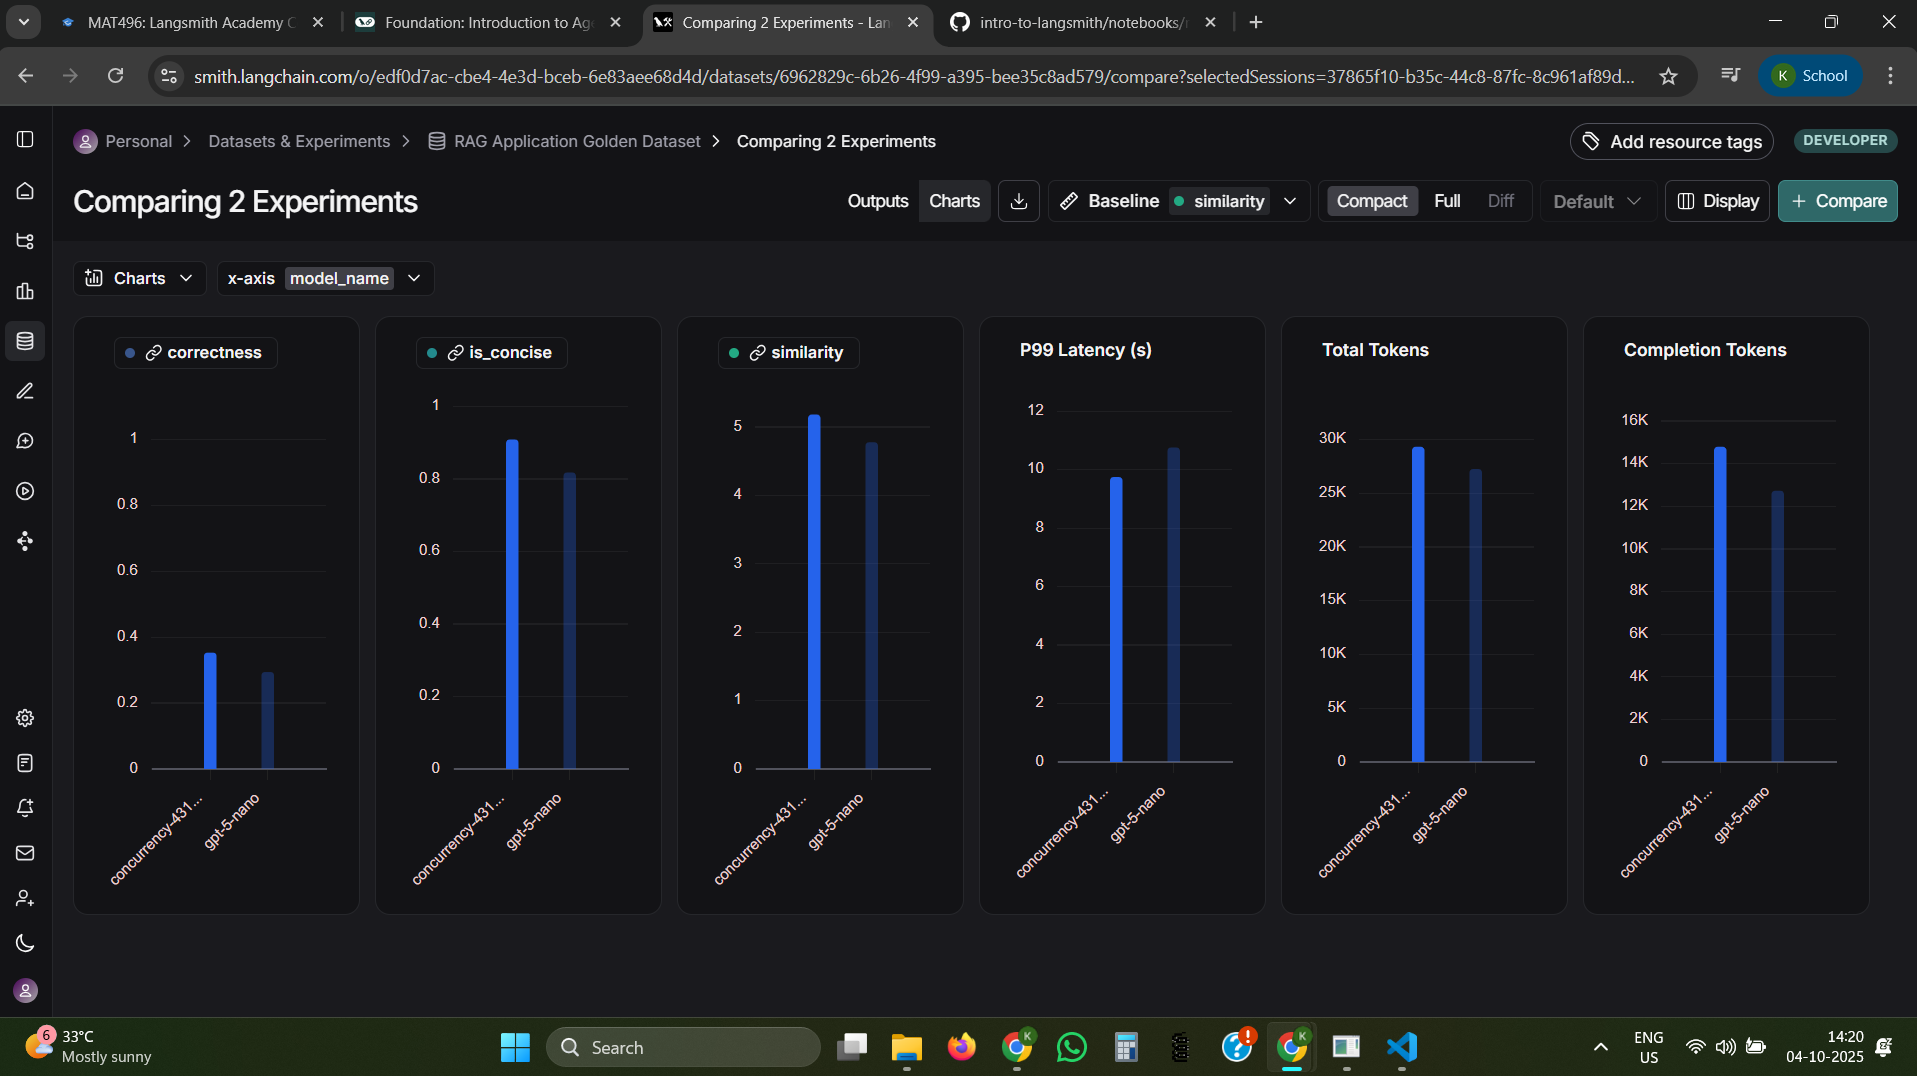


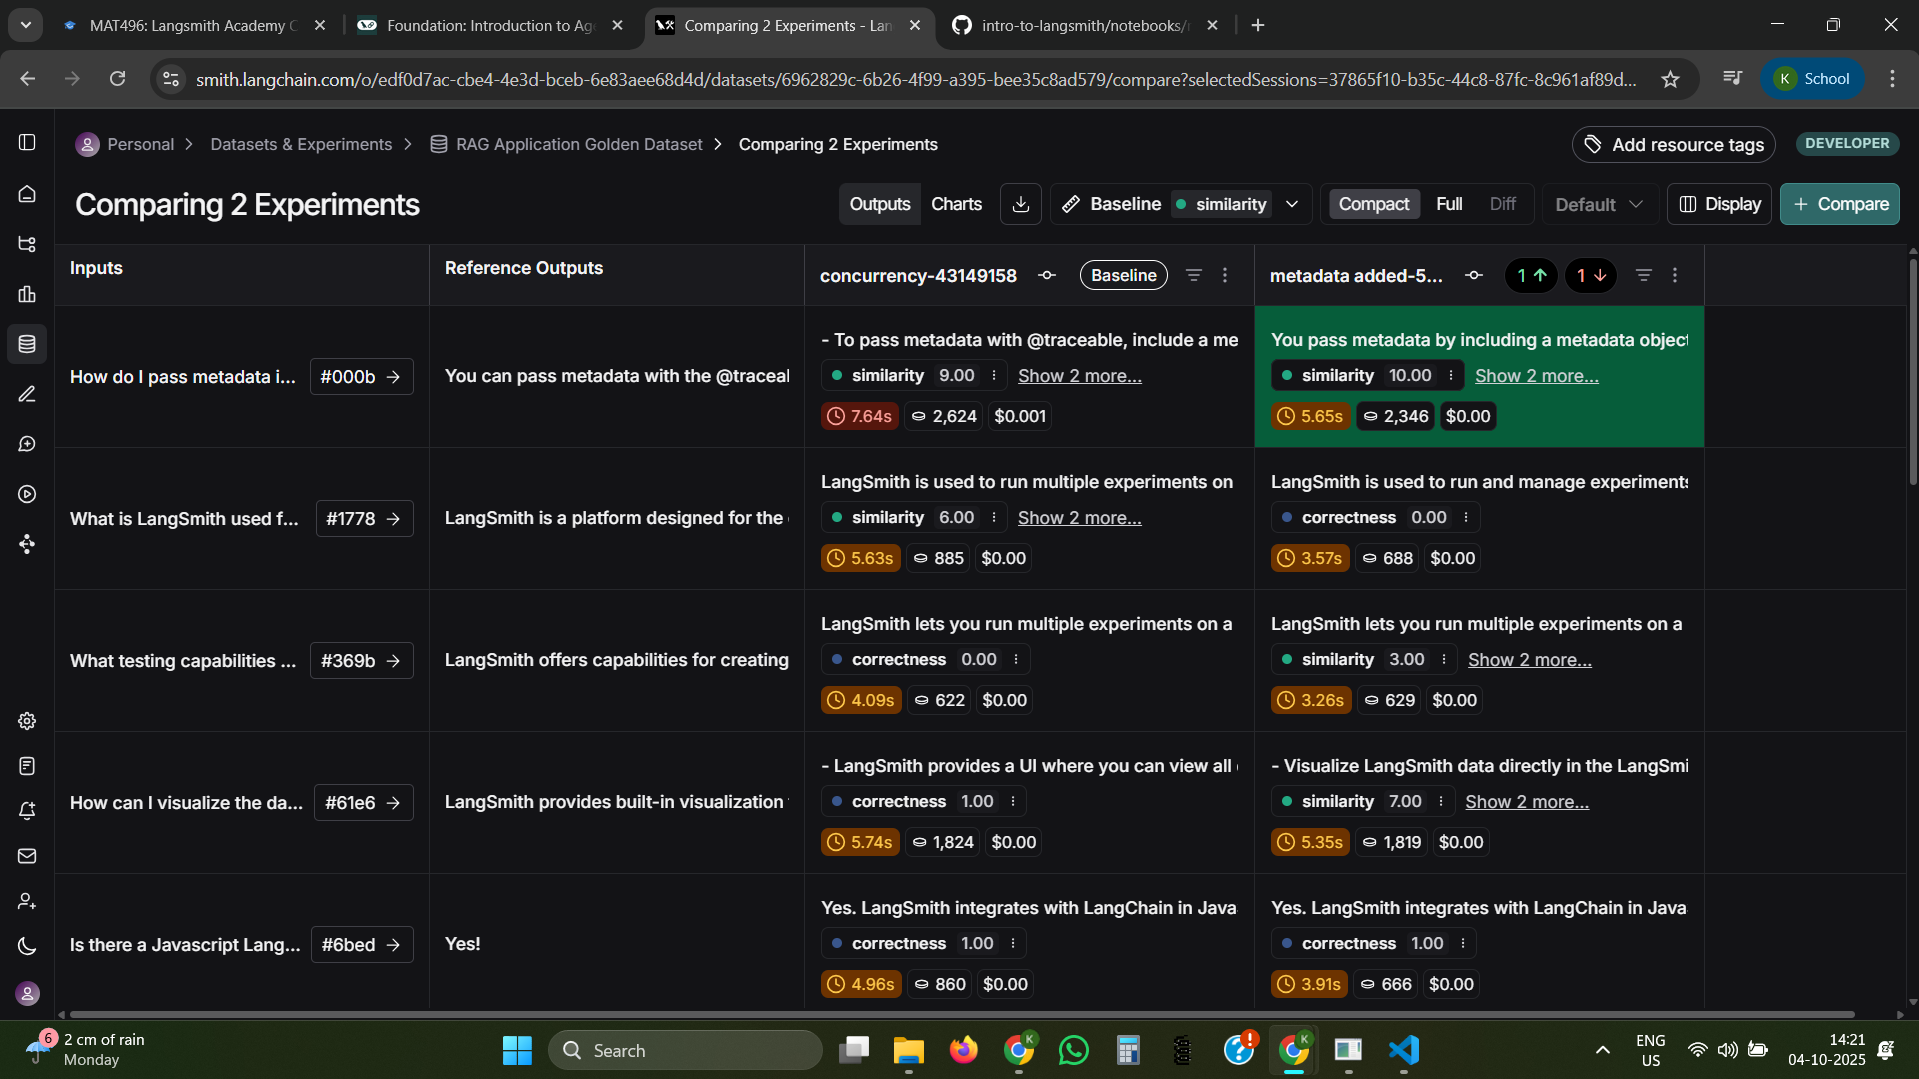


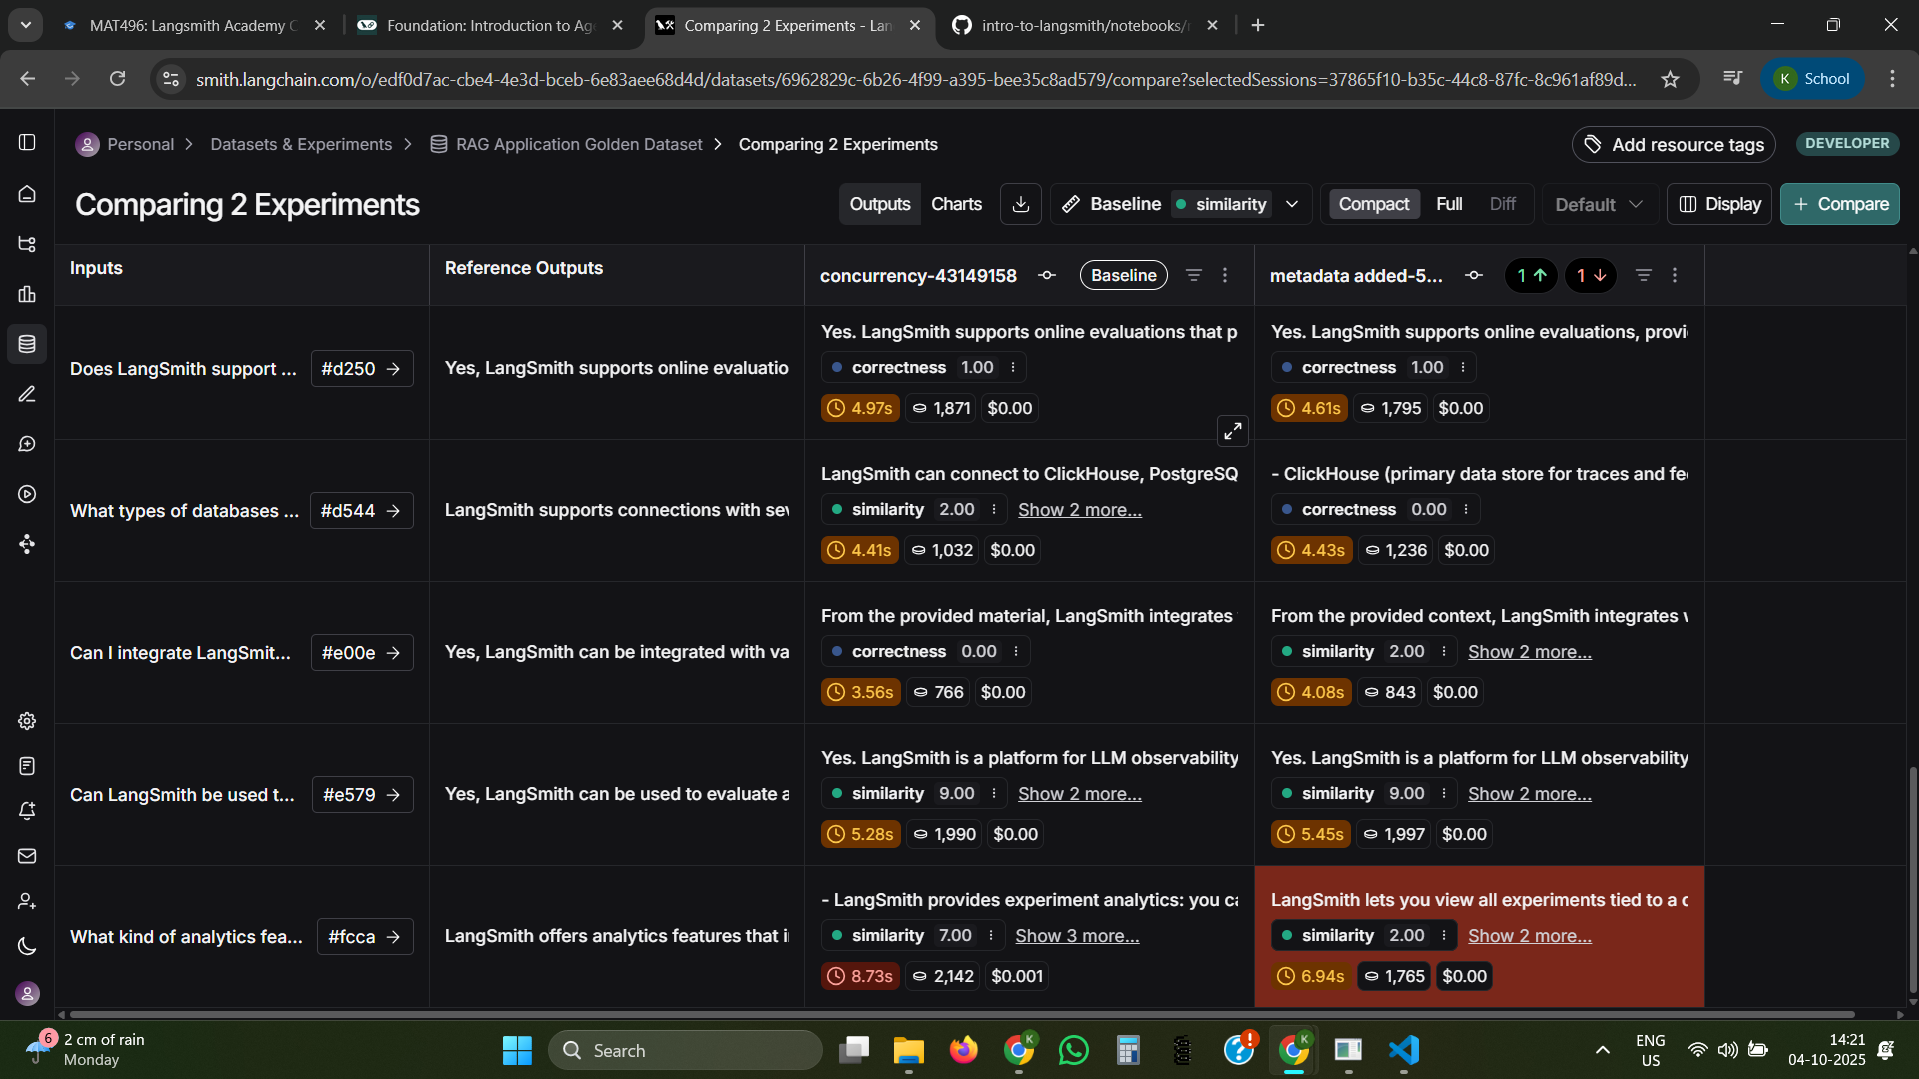

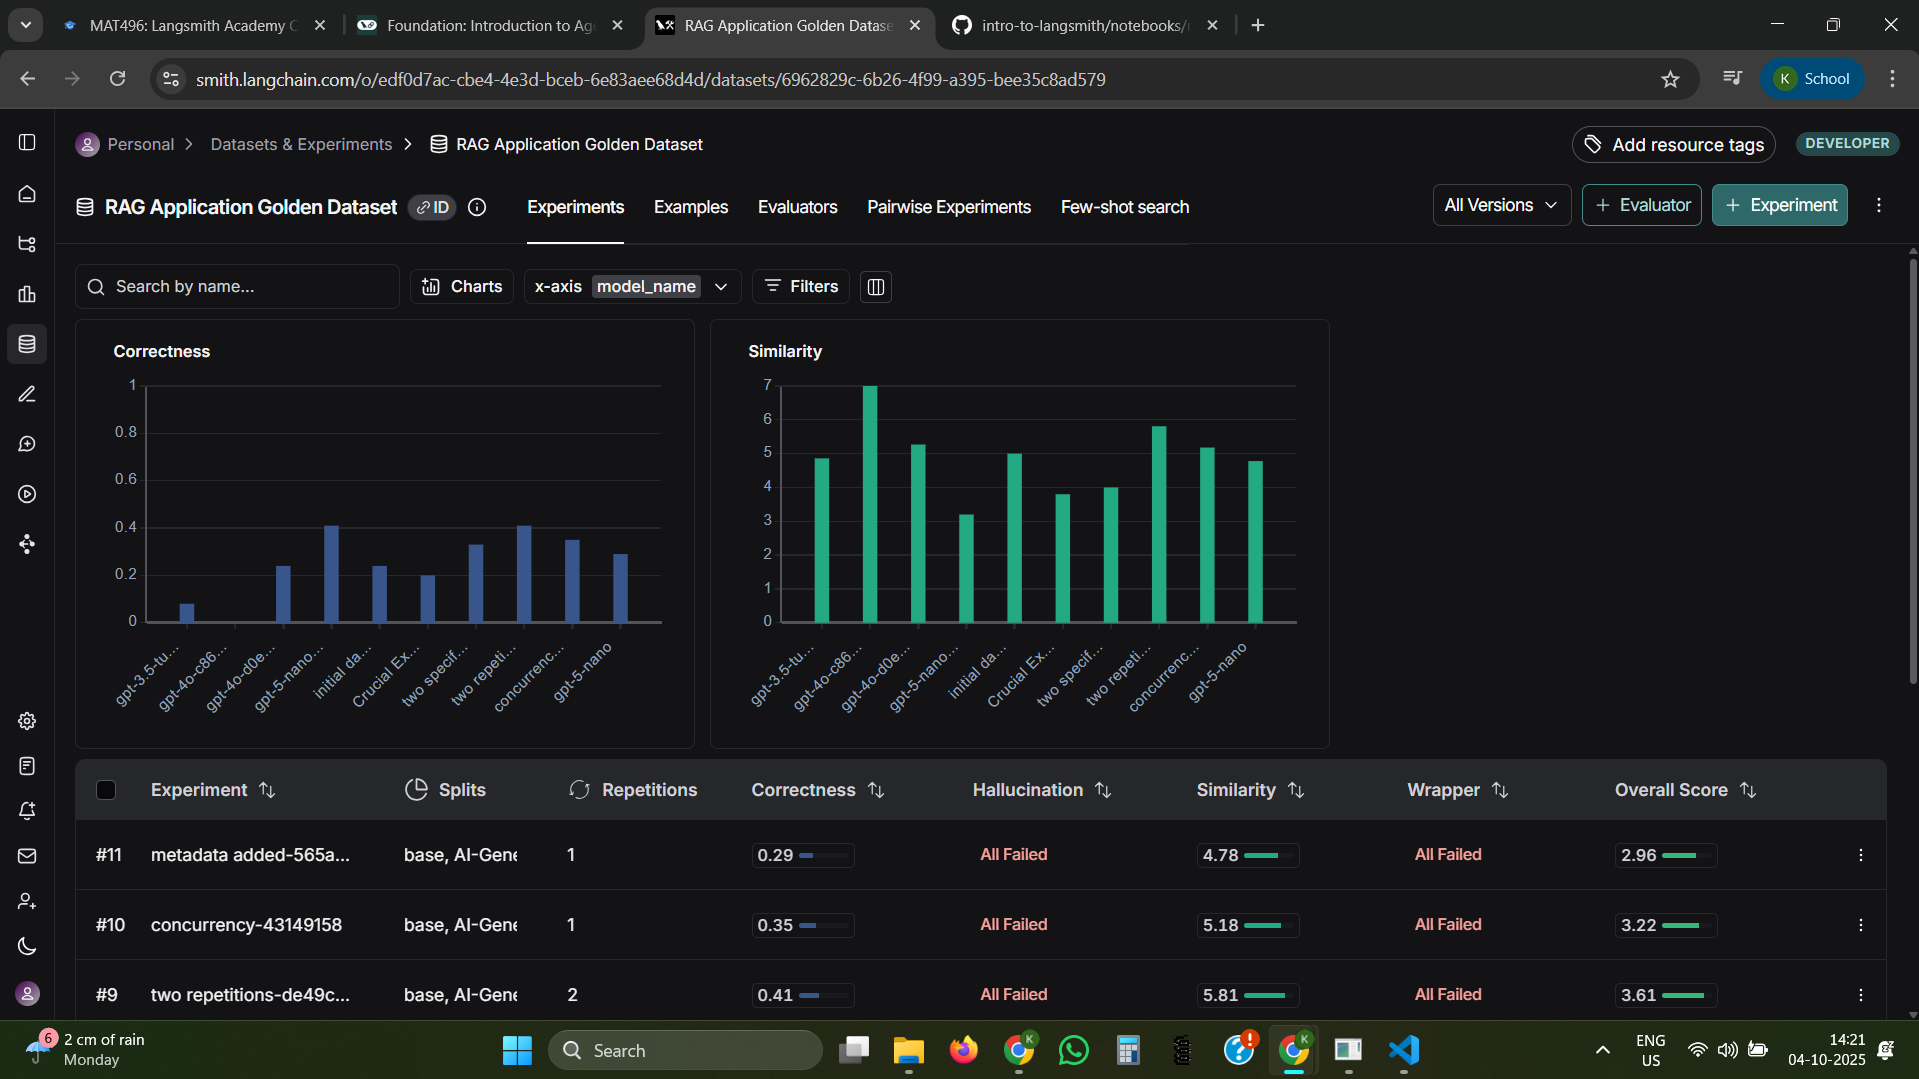

END